# Deep Learning for NLP

Silakan download file di bawah ini terlebih dahulu. Ukuran sekitar 800MB.

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-03-09 08:05:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-09 08:05:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-09 08:05:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

## Training Word2Vec

Import library yang dibutuhkan.

In [0]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
%matplotlib inline

Download stopwords yang disediakan oleh NLTK. 

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Saat ini tersedia stopwords untuk 23 bahasa (mungkin bertambah).

In [0]:
print(stopwords.fileids())

['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [0]:
STOPWORDS = set(stopwords.words('english'))

Download dataset bbc news.

In [0]:
url = "https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv"
df = pd.read_csv(url)

Cek jumlah artikel yang merupakan jumlah baris pada dataframe (`df`).

In [0]:
len(df)

2225

In [0]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


Bersihkan data, dan hilangkan stopwords.

In [0]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = df.copy()
df_clean['text'] = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [0]:
df_clean.head()

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


Terapkan lematisasi menggunakan library spacy. Cek https://spacy.io/

In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [0]:
df_clean.head()

,category,text,text_lemmatize
0,tech,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...,tiger wary farrell gamble leicester say rush m...
3,sport,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...
4,entertainment,ocean twelve raids box office ocean twelve cri...,ocean twelve raid box office ocean twelve crim...


In [0]:
df_clean["text"][0]

'tv future hands viewers home theatre systems plasma highdefinition tvs digital video recorders moving living room way people watch tv radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talkedabout technologies ces digital personal video recorders dvr pvr settop boxes like us tivo uk sky system allow people record store play pause forward wind tv programmes want essentially technology allows much personalised tv also builtin highdefinition tv sets big business japan us slower take europe lack highdefinition programming people forward wind adverts also forget abiding network channel schedules putting together alacarte entertainment us networks cable satellite companies worried means terms advertising revenues

In [0]:
df_clean["text_lemmatize"][0]

'tv future hand viewer home theatre system plasma highdefinition tvs digital video recorder move living room way people watch tv radically different five year time accord expert panel gather annual consumer electronic show las vegas discuss new technology impact one favourite pastime -PRON- lead trend programme content deliver viewer via home network cable satellite telecom company broadband service provider front room portable device one talkedabout technology ce digital personal video recorder dvr pvr settop box like -PRON- tivo uk sky system allow people record store play pause forward wind tv programme want essentially technology allow much personalised tv also builtin highdefinition tv set big business japan -PRON- slow take europe lack highdefinition program people forward wind advert also forget abide network channel schedule put together alacarte entertainment -PRON- network cable satellite company worry mean term advertising revenue well brand identity viewer loyalty channel a

Persiapkan list `sentences`, yang berisi list kata pada tiap kalimat.  
Dari `['saya dan dia', 'kamu dan mereka']` menjadi `[['saya', 'dan', 'dia'], ['kamu', 'dan', 'mereka']`.

In [0]:
sentences = [row.split() for row in df_clean['text_lemmatize']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

24582

Top-10 kata dengan jumlah kemunculan tertinggi.

In [0]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 'mr',
 'year',
 'would',
 'make',
 'also',
 'people',
 '-PRON-',
 'new',
 'one']

Buat objek dari constructor Word2Vec.

In [0]:
# min_count: minimum number of occurrences of a word in the corpus to be included in the model.
# window: the maximum distance between the current and predicted word within a sentence.
# size: the dimensionality of the feature vectors
# workers: number of workers, 
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4,
                     sg=1)

Bangun vocabulary.

In [0]:
# this line of code to prepare the model vocabulary
w2v_model.build_vocab(sentences)

Train word2vec model.

In [0]:
# train word vectors
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(986255, 2390515)

In [0]:
# Explore the model
w2v_model.wv.most_similar(positive=['money'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fund', 0.7607400417327881),
 ('raise', 0.6546962261199951),
 ('tax', 0.6127241849899292),
 ('pay', 0.6110708713531494),
 ('spend', 0.5930384397506714),
 ('much', 0.5794631242752075),
 ('buy', 0.5714608430862427),
 ('account', 0.5585447549819946),
 ('investment', 0.5525429248809814),
 ('rather', 0.5379403233528137)]

In [0]:
w2v_model.wv.most_similar(positive=['tv'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('digital', 0.6921852827072144),
 ('programme', 0.6774712800979614),
 ('content', 0.6237472891807556),
 ('series', 0.5887148380279541),
 ('life', 0.5806448459625244),
 ('broadband', 0.5741336345672607),
 ('music', 0.566057562828064),
 ('network', 0.5649639964103699),
 ('standard', 0.5641554594039917),
 ('radio', 0.5622063875198364)]

In [0]:
w2v_model.wv.similarity('device', 'digital')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7601628

In [0]:
w2v_model['money']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.282635  , -0.4190822 , -0.17965409,  0.05766556,  0.08315329,
        0.03992703,  0.11463436,  0.18855196, -0.0735189 , -0.0617126 ,
        0.27408496,  0.2249843 ,  0.11802156, -0.03378496,  0.3403971 ,
        0.05966548,  0.14903164,  0.27216232,  0.29331425, -0.07123836,
        0.18961836, -0.13166592, -0.34072858,  0.20885633,  0.47435486,
        0.04439577,  0.15138686,  0.20626725, -0.09365702, -0.04194044,
       -0.02736716, -0.10469677,  0.18554397,  0.09250008, -0.26584542,
        0.01917009,  0.09301648, -0.36838168,  0.17212456, -0.28467995,
       -0.00576672,  0.0629783 ,  0.3337321 ,  0.34882158, -0.13269196,
       -0.01342163, -0.09792556, -0.11088574, -0.08768423, -0.49677008,
       -0.40698883, -0.01262065, -0.45261428,  0.09438347, -0.13467647,
        0.2135769 ,  0.06923588,  0.31464404,  0.02240152,  0.35100564,
       -0.00274835,  0.26037797, -0.07927017,  0.0141255 ,  0.2030855 ,
       -0.10895165,  0.2609591 , -0.0808733 , -0.2936611 , -0.04

In [0]:
w2v_model['gadget'].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(100,)

## Text Classification with LSTM

Kali ini kita akan coba menggunakan LSTM untuk melakukan klasifikasi teks.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


`vocab_size`: hanya menggunakan top-5000 vocab dari total 24582. Hal ini untuk mempercepat waktu training.  
`embedding_dim`: dimensi vektor representasi setiap token.  
`max_length`: maksimal jumlah token dalam satu artikel/sample data.  
`trunc_type = post`: jika melebihi `max_length`, pemotongan dilakukan di bagian akhir.  
`oov_tok`: pengganti token yang tidak ada dalam vocab.

*Sebaiknya menyebutkan token atau kata?*

In [0]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

Split data menjadi 80% training dan 20% validasi.

In [0]:
train_size = int(len(df_clean) * training_portion)
train_set = df_clean[0: train_size]
validation_set = df_clean[train_size:]

In [0]:
len(train_set), len(validation_set)

(1780, 445)

Tokenisasi menggunakan library `keras`. Fit `tokenizer` **hanya pada training set**.

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_set["text"])
word_index = tokenizer.word_index

In [0]:
list(word_index.items())[0:10]

[('<OOV>', 1),
 ('said', 2),
 ('mr', 3),
 ('would', 4),
 ('also', 5),
 ('people', 6),
 ('new', 7),
 ('us', 8),
 ('year', 9),
 ('one', 10)]

Encode sekuen token ke dalam sekuen id.

In [0]:
train_sequences = tokenizer.texts_to_sequences(train_set["text"])

In [0]:
print(train_sequences[10])

[2248, 1, 1, 24, 631, 548, 1, 1, 1, 1618, 1, 1, 2248, 24, 520, 1, 1, 148, 248, 1, 148, 248, 785, 784, 602, 2139, 1, 1570, 1, 1596, 1, 1, 1, 1, 1, 4479, 1, 1, 108, 4258, 1, 2, 2669, 1396, 321, 4480, 1, 48, 337, 1, 321, 2009, 3717, 37, 24, 3560, 1, 1, 1, 1, 503, 1, 1, 1, 812, 576, 2316, 318, 4734, 1, 345, 24, 1, 728, 2249, 1, 4067, 121, 10, 1, 3429, 620, 3310, 1, 24, 1, 373, 784, 602, 1, 80, 14, 577, 1, 1, 1, 555, 1570, 937, 1, 1, 823, 1734, 130, 1, 1, 1, 2764, 24, 1, 99, 248, 1, 1483, 4735, 503, 454, 1, 1338, 4481, 712, 1279, 1, 1732, 10, 38, 631, 292, 1, 69, 443, 520, 280, 1484, 24, 437, 1, 1, 1544, 1, 775, 1, 2965, 1, 1464, 5, 1, 2248, 520, 24, 2762, 1, 1, 1, 1, 1, 813, 41, 1693, 27, 895, 1, 814, 24, 348, 24, 14, 280, 1484, 1244, 20, 72, 979, 1002, 4068, 249]


Potong sekuens ids (jika melebihi `max_length`) atau tambahkan padding (jika kurang dari `max_length`).

In [0]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
print('before pad_sequences: ',len(train_sequences[0]))
print('after pad_sequences: ',len(train_padded[0]))

print('before pad_sequences: ',len(train_sequences[1]))
print('after pad_sequences: ',len(train_padded[1]))

print('before pad_sequences: ',len(train_sequences[10]))
print('after pad_sequences: ',len(train_padded[10]))

before pad_sequences:  404
after pad_sequences:  200
before pad_sequences:  183
after pad_sequences:  200
before pad_sequences:  176
after pad_sequences:  200


Perbandingan data sebelum dan setelah padding.

In [0]:
print(np.asarray(train_sequences[10]))

[2248    1    1   24  631  548    1    1    1 1618    1    1 2248   24
  520    1    1  148  248    1  148  248  785  784  602 2139    1 1570
    1 1596    1    1    1    1    1 4479    1    1  108 4258    1    2
 2669 1396  321 4480    1   48  337    1  321 2009 3717   37   24 3560
    1    1    1    1  503    1    1    1  812  576 2316  318 4734    1
  345   24    1  728 2249    1 4067  121   10    1 3429  620 3310    1
   24    1  373  784  602    1   80   14  577    1    1    1  555 1570
  937    1    1  823 1734  130    1    1    1 2764   24    1   99  248
    1 1483 4735  503  454    1 1338 4481  712 1279    1 1732   10   38
  631  292    1   69  443  520  280 1484   24  437    1    1 1544    1
  775    1 2965    1 1464    5    1 2248  520   24 2762    1    1    1
    1    1  813   41 1693   27  895    1  814   24  348   24   14  280
 1484 1244   20   72  979 1002 4068  249]


Token padding adalah `0`.

In [0]:
print(train_padded[10])

[2248    1    1   24  631  548    1    1    1 1618    1    1 2248   24
  520    1    1  148  248    1  148  248  785  784  602 2139    1 1570
    1 1596    1    1    1    1    1 4479    1    1  108 4258    1    2
 2669 1396  321 4480    1   48  337    1  321 2009 3717   37   24 3560
    1    1    1    1  503    1    1    1  812  576 2316  318 4734    1
  345   24    1  728 2249    1 4067  121   10    1 3429  620 3310    1
   24    1  373  784  602    1   80   14  577    1    1    1  555 1570
  937    1    1  823 1734  130    1    1    1 2764   24    1   99  248
    1 1483 4735  503  454    1 1338 4481  712 1279    1 1732   10   38
  631  292    1   69  443  520  280 1484   24  437    1    1 1544    1
  775    1 2965    1 1464    5    1 2248  520   24 2762    1    1    1
    1    1  813   41 1693   27  895    1  814   24  348   24   14  280
 1484 1244   20   72  979 1002 4068  249    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

Lakukan hal yang sama untuk data validasi.

In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_set['text'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


Ubah label ke dalam numerik.

In [0]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df_clean['category'])

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_set['category']))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_set['category']))

In [0]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


Sebelum kita mulai klasifikasi, mari kita lihat perubahan yang terjadi dari pada training data dalam format teks. Kata yang tidak ada dalam vocabulary (OOV) sudah digantikan dengan token khusus, dan ditambahkan `pad_token` yang didecode sebagai `?`.

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_set['text'][10])

berlin <OOV> <OOV> film german movie <OOV> <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> arrested <OOV> brother <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> <OOV> <OOV> summer arrested dropped <OOV> <OOV> university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film entitled <OOV> <OOV> <OOV> <O

### Model

Pertama kita perlu `Embedding` layer untuk mengubah token id menjadi vektor. Saat ini, weights dari embedding layer akan ditrain bersamaan dengan proses training semua layer.  
Lalu sebuah `LSTM` layer dengan **jumlah `units`** dalam contoh ini yaitu 64.  
Terakhir kita tambahkan 2 buah Dense layer.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 357,574
Trainable params: 357,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train model yang telah dibuat.

In [0]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 16s - loss: 1.6743 - acc: 0.2309 - val_loss: 1.5764 - val_acc: 0.3461
Epoch 2/10
1780/1780 - 15s - loss: 1.4306 - acc: 0.3309 - val_loss: 1.4062 - val_acc: 0.3258
Epoch 3/10
1780/1780 - 15s - loss: 1.3622 - acc: 0.3348 - val_loss: 1.3773 - val_acc: 0.3281
Epoch 4/10
1780/1780 - 15s - loss: 1.3161 - acc: 0.3320 - val_loss: 1.2902 - val_acc: 0.3416
Epoch 5/10
1780/1780 - 15s - loss: 1.3150 - acc: 0.3416 - val_loss: 1.5291 - val_acc: 0.2157
Epoch 6/10
1780/1780 - 15s - loss: 1.2883 - acc: 0.4000 - val_loss: 1.1470 - val_acc: 0.4674
Epoch 7/10
1780/1780 - 15s - loss: 1.1622 - acc: 0.4551 - val_loss: 1.3845 - val_acc: 0.3528
Epoch 8/10
1780/1780 - 15s - loss: 1.2948 - acc: 0.4449 - val_loss: 1.2780 - val_acc: 0.4337
Epoch 9/10
1780/1780 - 15s - loss: 1.2035 - acc: 0.4764 - val_loss: 1.2619 - val_acc: 0.4000
Epoch 10/10
1780/1780 

Plot accuracy dan error dari traning dan validation. Terlihat dalam 10 epochs, akurasi validasi di sekitar 50%.

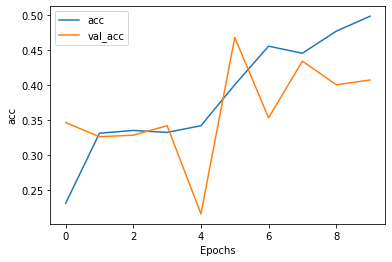

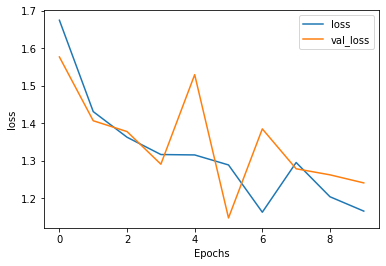

In [0]:

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## BiLSTM

Sekarang kita akan coba menggunakan Bidirectional LSTM. `tf.keras` sudah menyiapkan layer khusus yang langsung bisa digunakan, yaitu `tf.keras.layers.Bidirectional`. Terlihat bahwa jumlah parameter pada layer bidirectional tepat 2 kali jumlah parameter di LSTM biasa.

In [0]:
model_bi = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_bi.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainabl

In [0]:
model_bi.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_bi.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 30s - loss: 1.6063 - acc: 0.2888 - val_loss: 1.3663 - val_acc: 0.4337
Epoch 2/10
1780/1780 - 29s - loss: 1.0884 - acc: 0.5483 - val_loss: 0.8304 - val_acc: 0.8180
Epoch 3/10
1780/1780 - 29s - loss: 0.4889 - acc: 0.8326 - val_loss: 0.3913 - val_acc: 0.8764
Epoch 4/10
1780/1780 - 29s - loss: 0.1729 - acc: 0.9404 - val_loss: 0.3231 - val_acc: 0.9034
Epoch 5/10
1780/1780 - 29s - loss: 0.0507 - acc: 0.9876 - val_loss: 0.3280 - val_acc: 0.8989
Epoch 6/10
1780/1780 - 29s - loss: 0.0284 - acc: 0.9944 - val_loss: 0.3546 - val_acc: 0.8944
Epoch 7/10
1780/1780 - 29s - loss: 0.0109 - acc: 0.9983 - val_loss: 0.3388 - val_acc: 0.9169
Epoch 8/10
1780/1780 - 29s - loss: 0.0454 - acc: 0.9860 - val_loss: 0.3355 - val_acc: 0.9124
Epoch 9/10
1780/1780 - 29s - loss: 0.0081 - acc: 0.9983 - val_loss: 0.2512 - val_acc: 0.9169
Epoch 10/10
1780/1780 - 29s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2585 - val_acc: 0.9258


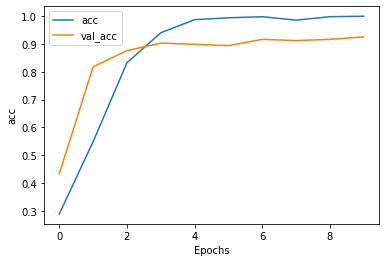

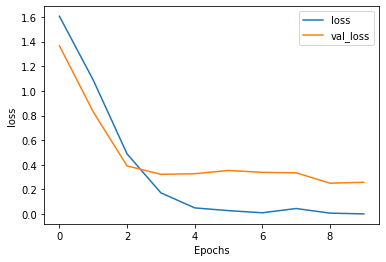

In [0]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## CNN

Salah satu alasan menggunakan Bidirectional adalah perlunya kemampuan melihat input di depan (tidak hanya input sebelumnya). Maka Bidirectional bukan satu-satunya alternatif. CNN juga bisa menjadi alternatif karena CNN akan melihat beberapa input sebelum dan sesudah berdasarkan size filter yang diberikan.  
  
Di bawah ini, kita coba menggunakan jumlah filter sebanyak 128 dengan ukuran kernel 5.

In [0]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                             input_length=max_length),
    # specify the number of convolutions that you want to learn, their size, and their activation function.
    # words will be grouped into the size of the filter in this case 5
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 369,734
Trainable params: 369,734
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_cnn.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 0s - loss: 6.3444e-06 - acc: 1.0000 - val_loss: 0.1455 - val_acc: 0.9640
Epoch 2/10
1780/1780 - 0s - loss: 1.8314e-06 - acc: 1.0000 - val_loss: 0.1510 - val_acc: 0.9640
Epoch 3/10
1780/1780 - 0s - loss: 7.9334e-07 - acc: 1.0000 - val_loss: 0.1587 - val_acc: 0.9640
Epoch 4/10
1780/1780 - 0s - loss: 5.1956e-07 - acc: 1.0000 - val_loss: 0.1561 - val_acc: 0.9640
Epoch 5/10
1780/1780 - 0s - loss: 3.7002e-07 - acc: 1.0000 - val_loss: 0.1614 - val_acc: 0.9640
Epoch 6/10
1780/1780 - 0s - loss: 2.8369e-07 - acc: 1.0000 - val_loss: 0.1653 - val_acc: 0.9640
Epoch 7/10
1780/1780 - 0s - loss: 2.2328e-07 - acc: 1.0000 - val_loss: 0.1630 - val_acc: 0.9640
Epoch 8/10
1780/1780 - 0s - loss: 1.7868e-07 - acc: 1.0000 - val_loss: 0.1648 - val_acc: 0.9640
Epoch 9/10
1780/1780 - 0s - loss: 1.4908e-07 - acc: 1.0000 - val_loss: 0.1638 - val_acc: 0.9640
Epoch 10/10
1780/1780 - 0s - loss: 1.2343e-07 - acc: 1.0000 - val_loss: 0.1675 - val_acc:

Dari plot, kita bisa lihat bahwa hasilnya hampir sama dengan model BiLSTM bahkan terlihat sedikit lebih baik.

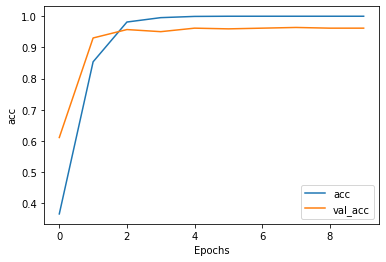

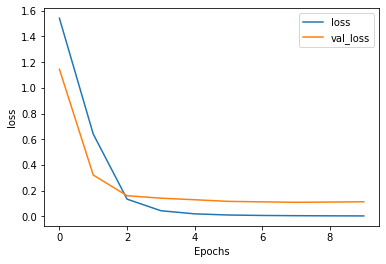

In [0]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Glove+CNN+LSTM

Kali ini kita coba untuk menggabungkan beberapa komponen, yaitu menggunakan `pretrained embedding matrix`, bisa menggunakan word2vec, namun di sini kita coba menggunakan Glove. Info tentang Glove: https://nlp.stanford.edu/projects/glove/. Ada beberapa pilihan Glove, kita coba menggunakan 100 dimensi.

Lalu kita tambahkan CNN dan LSTM setelahnya.

In [0]:
word_index = tokenizer.word_index
vocab_size=len(word_index)
embedding_dim = 100

Bentuk `embeddings_matrix` yang hanya berisi vektor kata yang ada dalam kamus dataset yang kita gunakan saat ini (BBC train).

In [0]:
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;



embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

FileNotFoundError: ignored

Karena kita sudah menggunakan pretrained embeddings matrix, maka kita bisa set agar tidak mengupdate/learn weights nya. Set `trainable=False`.  
Dari summary model terlihat bahwa meskipun jumlah total parameter jauh lebih banyak dari model-model sebelumnya, namun yang ditrain jauh lebih sedikit.

In [0]:
model_combi = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_combi.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_combi.summary()

NameError: ignored

In [0]:
model_combi.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_combi.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

NameError: ignored

Salah satu perbedaan yang terlihat adalah, hasil akurasi validasi pada epoch 1 sudah >80%, dibanding model sebelumnya yang berkisar 50%. Hal ini merupakan efek penggunaan pretrained word embeddings.

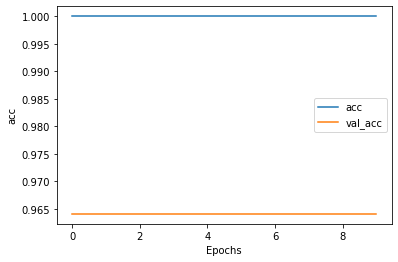

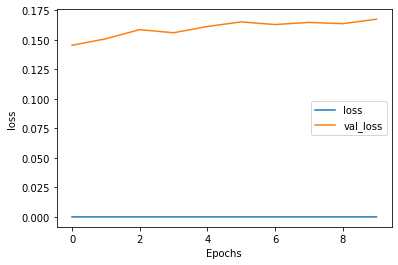

In [0]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Transformers

Terakhir, mari kita coba menggunakan pretrained contextual word embeddings. Transformers menyediakan banyak sekali pilihan.

Install transformers dari huggingface https://huggingface.co/.

In [0]:
!pip install transformers

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 9.2MB/s 
     |████████████████████████████████| 870kB 18.4MB/s 
     |████████████████████████████████| 3.7MB 21.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=9f7fe0953116e96e6494d1f240232f5cd28dcce692b17db62d92dd83f5538e09
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


Import beberapa library yang dibutuhkan.

In [0]:
import torch
import transformers as tfm # pytorch transformers
from sklearn.linear_model import LogisticRegression

Ada banyak model transformer yang bisa digunakan, saat ini kita coba menggunakan distilBERT. Model lainnya dapat dilihat di https://huggingface.co/transformers/pretrained_models.html

In [0]:
model_class, tokenizer_class, pretrained_weights = (tfm.DistilBertModel, tfm.DistilBertTokenizer, 'distilbert-base-uncased')

Load tokenizer dan juga model.

In [0]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Tokenize train_set dan juga validation_set. 

In [0]:
train_sequences = train_set['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (761 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1046 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [0]:
validation_sequences = validation_set['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (986 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [0]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Ubah `train_padded` dan `validation_padded` ke dalam bentuk tensor. Lalu jalankan model (forward pass). DistilBERT memiliki hidden unit sebanyak 768.

In [0]:
train_ids = torch.tensor(np.array(train_padded)).to(torch.int64)
with torch.no_grad():
    train_last_hidden_states = model(train_ids)

In [0]:
validation_ids = torch.tensor(np.array(validation_padded)).to(torch.int64)
with torch.no_grad():
    validation_last_hidden_states = model(validation_ids)

Shape dari `last_hidden_states` yaitu `[jumlah data, panjang sekuens, jumlah hidden units]`.

In [0]:
train_last_hidden_states[0].shape

torch.Size([1780, 200, 768])

Untuk teks classification, kita bisa menggunakan hanya output posisi pertama dari 200 output yang dikeluarkan model. Karena terdapat self-attention di dalam model tersebut, maka setiap posisi output akan memiliki aliran informasi dari semua posisi input, tidak hanya dari posisi input yang bersesuaian.

In [0]:
train_features = train_last_hidden_states[0][:,0,:].numpy()

In [0]:
validation_features = validation_last_hidden_states[0][:,0,:].numpy()

In [0]:
train_features[0]

array([ 2.48080388e-01,  2.04793781e-01,  3.78549397e-01,  4.46929008e-01,
        1.50833189e-01, -1.44618765e-01,  1.13854431e-01,  4.42507595e-01,
       -3.30757827e-01, -1.41197607e-01,  2.53597379e-01, -2.92316824e-01,
       -3.27488147e-02,  4.58119363e-01, -2.69518465e-01,  2.41658166e-01,
        5.91956964e-03,  5.04540801e-01, -2.48884261e-02,  4.08302814e-01,
        5.01435041e-01, -8.51372182e-02,  3.07783157e-01, -6.98667318e-02,
        2.80450314e-01, -2.27801248e-01, -1.52133852e-01, -1.47802634e-02,
        1.68139562e-01,  1.15813367e-01, -4.22211923e-02, -1.93968475e-01,
       -2.13252693e-01, -3.33143920e-01,  2.23356366e-01, -4.63325679e-02,
        3.97536904e-01,  6.09043278e-02, -4.38380599e-01,  1.80372804e-01,
       -5.69559574e-01, -7.48178735e-02,  2.52979159e-01,  2.83001531e-02,
        3.40195507e-01,  3.44524533e-02, -3.27709556e-01, -3.58494878e-01,
        1.54593289e-01, -5.66175133e-02, -2.95305867e-02, -1.46187335e-01,
       -2.62136385e-02, -

In [0]:
train_label = training_label_seq.squeeze()
validation_label = validation_label_seq.squeeze()

Coba gunakan logistic regression sederhana untuk melakukan klasifikasi.

In [0]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(train_features, train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Ternyata akurasi train dan validationnya cukup tinggi.

In [0]:
lr_clf.score(train_features, train_label)

0.998876404494382

In [0]:
lr_clf.score(validation_features, validation_label)

0.9550561797752809

## PoS Tagging with LSTM

Originally from https://nlpforhackers.io/lstm-pos-tagger-keras/

In [0]:
import nltk
import numpy as np

nltk.download('treebank')
 
tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


In [0]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))
 
# Let's see how a sequence looks
 
print(sentences[5])
print(sentence_tags[5])

['Lorillard' 'Inc.' ',' 'the' 'unit' 'of' 'New' 'York-based' 'Loews'
 'Corp.' 'that' '*T*-2' 'makes' 'Kent' 'cigarettes' ',' 'stopped' 'using'
 'crocidolite' 'in' 'its' 'Micronite' 'cigarette' 'filters' 'in' '1956'
 '.']
['NNP' 'NNP' ',' 'DT' 'NN' 'IN' 'JJ' 'JJ' 'NNP' 'NNP' 'WDT' '-NONE-' 'VBZ'
 'NNP' 'NNS' ',' 'VBD' 'VBG' 'NN' 'IN' 'PRP$' 'NN' 'NN' 'NNS' 'IN' 'CD'
 '.']


In [0]:
from sklearn.model_selection import train_test_split

(train_sentences, 
 test_sentences, 
 train_tags, 
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

In [0]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())
 
for ts in train_tags:
    for t in ts:
        tags.add(t)
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding

In [0]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []
 
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
 
for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)
 
for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])
 
for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])
 
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[8453, 7455, 3751, 7272, 3871, 8427, 6174, 9645, 4483, 2082, 8721, 4379, 7455, 9522, 146, 7272, 1512, 4656, 8859, 3154, 3924, 509, 833, 6193, 221, 4045, 3518, 7455, 3990, 2289]
[7812, 7432, 3077, 1, 5519, 2170, 8355, 9661, 1022, 5430, 1, 9645, 7035, 2289]
[24, 1, 13, 18, 46, 26, 46, 24, 2, 11, 13, 14, 1, 23, 13, 18, 1, 13, 12, 32, 33, 30, 24, 13, 24, 13, 24, 1, 11, 16]
[3, 11, 45, 44, 44, 46, 40, 20, 26, 24, 46, 24, 30, 16]


In [0]:
MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)  # 271

271


In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word2index), 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(tag2index))),
    tf.keras.layers.Activation('softmax')
])
model.summary() 
 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         1296384   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         788480    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 47)          24111     
_________________________________________________________________
activation (Activation)      (None, None, 47)          0         
Total params: 2,108,975
Trainable params: 2,108,975
Non-trainable params: 0
_________________________________________________________________


In [0]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [0]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=10, validation_split=0.2)

Train on 2504 samples, validate on 627 samples
Epoch 1/10
2504/2504 [==============================] - 16s 6ms/sample - loss: 1.3091 - acc: 0.8589 - val_loss: 0.3673 - val_acc: 0.9095
Epoch 2/10
2504/2504 [==============================] - 15s 6ms/sample - loss: 0.3408 - acc: 0.9109 - val_loss: 0.3107 - val_acc: 0.9085
Epoch 3/10
2504/2504 [==============================] - 15s 6ms/sample - loss: 0.3137 - acc: 0.9096 - val_loss: 0.2988 - val_acc: 0.9187
Epoch 4/10
2504/2504 [==============================] - 15s 6ms/sample - loss: 0.3026 - acc: 0.9168 - val_loss: 0.2895 - val_acc: 0.9193
Epoch 5/10
2504/2504 [==============================] - 15s 6ms/sample - loss: 0.2937 - acc: 0.9171 - val_loss: 0.2815 - val_acc: 0.9193
Epoch 6/10
2504/2504 [==============================] - 15s 6ms/sample - loss: 0.2860 - acc: 0.9177 - val_loss: 0.2769 - val_acc: 0.9208
Epoch 7/10
2504/2504 [==============================] - 15s 6ms/sample - loss: 0.2817 - acc: 0.9188 - val_loss: 0.2708 - val_acc: 0

In [0]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")   

783/783 [==============================] - 4s 5ms/sample - loss: 0.2664 - acc: 0.9265
acc: 92.6477313041687
